In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, norm, expon

<h1 align="center"><b><u>Lecture 2 - The Monte Carlo Method</u></b></h1>

<h2>Importance Sampling</h2>

This notebook implements the importance sampling example seen in Lecture 2, and compares the efficency of this to the standard Monte Carlo method.

The example attempts to estimate the probability that a component will last more than 25 years, given that the lifetimes are exponentially distributed $T_{\text{life}} \sim p(x) = \begin{cases} e^{-x} &
          x \geq 0 \\
      0 & x<0\end{cases}$, with an expected life-time of one year.  We want to use Monte Carlo methods to esetimate the following expectation:

$$
\begin{eqnarray*}
			I = P(T_{\text{life}} \geq 25) &=& \mathbb{E}\{I_{\{T_{\text{life}}\geq25\}}\}\\
			                                    &=& \int_{-\infty}^{+\infty}I_{\{x\geq25\}}p(x)dx\\
			                                    &=& \int_{0}^{+\infty}I_{\{x\geq25\}}e^{-x}dx
\end{eqnarray*}
$$

We can calculate this integral analytically, but the setup is used to motivate the use of, and provide intuition behind improtance sampling. To uncover the limitations for basic Monte Carlo in this scenario, we look at the acceptance rate of the sampler, which we can (in this particular case) derive analytically.

$$
\frac{1}{N} \sum_{i=1}^{N} I_{\{X^{(i)} \geq 25\}}
$$
with each $X^{(i)} \sim p(x) $

However, this will not work in practice.  Calculating this gives us the probability of accepting a sample using the standard MC scheme. 

In [37]:
mu = 25
I = np.exp(-mu)
print("I = {}".format(I))

I = 1.3887943864964021e-11


This means that for a single sample to have a contribution to the estimate, on average $1/I$ samples must be taken.  The notebook cell below calculates how long this notebook would take to produce a single accepted sample.

In [38]:
from timeit import timeit
s_per_loop = timeit(lambda:expon.rvs(),number=10000)/10000
secs = s_per_loop * (1/I)
days = secs/(60*60*24)

print("Time to collect a non-rejected sample: {} days".format(round(days)))

Time to collect a non-rejected sample: 22 days


This is completely impractical.  The solution to this is the importance sampler.  A new density, $q(x)$, is chosen such that $q(x)\neq0$ when $p(x)\neq0$ (recall $X^{(i)} \sim p(x)$).  This new density is aligned with the important regions of the space.  Since we are considering a lifetime of 25 years or more, the important region of space is almost all concentrated around $T_{\text{life}}=25$.  A sensible choice for the new density could be $q(x) = \mathcal{N}(25,1)$.  Samples $\{X^{i}\}_{i=1}^N$ are now taken from this density instead.

In [44]:
N = 2000
qx_samples = norm.rvs(size=N,loc=mu,scale=1)

The importance sampling estimate requires a different weighting of each sample, defined below:

$$
I = \mathbb{E}_p \{f(X)\} = \mathbb{E}_q \{\frac{f(X)p(X)}{q(X)}\}
$$

so the estimate becomes:

$$
I^{*} = \frac{1}{N}\sum_{i=1}^{N} \frac{f(X^{(i)})p(X^{(i)})}{q(X^{(i)})}
$$

The function below gives the importance weight for each sample.

In [45]:
def importance(x):
    if x>=mu:
        return expon.pdf(x)/norm.pdf(x,loc=mu,scale=1)
    else: 
        return 0

The importance sampling estimate is shown below, and compared to the true expectation.

In [46]:
MCE = (1/N) * sum([importance(x) for x in qx_samples])
print("True P: {}, Importance Sampling Estimate: {}".format(I,MCE))

True P: 1.3887943864964021e-11, Importance Sampling Estimate: 1.3836550695681616e-11


The importance sampler is able to form accurate estimates efficiently by suggesting a new density that covers the more important regions of space.  This is visualised below, showing why the new density has a much higher acceptance ratio.

In [47]:
x = np.linspace(0,12,1000)
y1 = expon.pdf(x)
y2 = norm.pdf(x,loc=7)

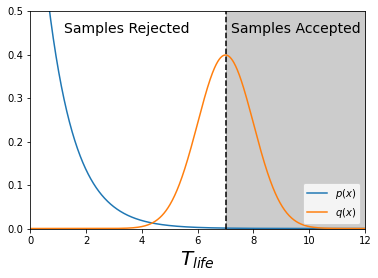

In [48]:
plt.plot(x,y1,label=r"$p(x)$")
plt.plot(x,y2,label=r"$q(x)$")
plt.axvline(7,color='k',linestyle='--')
plt.fill_between((7,12),(0.5,0.5),color='k',alpha=0.2)
plt.annotate("Samples Accepted",xy=(0.6,0.9),xycoords="axes fraction",fontsize=14)
plt.annotate("Samples Rejected",xy=(0.1,0.9),xycoords="axes fraction",fontsize=14)
plt.legend(loc="lower right")
plt.xlabel(r"$T_{ life }$",fontsize=20)
plt.xlim(0,12)
plt.ylim(0,0.5)
plt.show()